### A quick demonstration of temperature+polarization wiener filtering

In [1]:
import numpy as np
import healpy as hp
from matplotlib.pyplot import *
# from cmblensplus/wrap/
import basic
import curvedsky as cs
# from cmblensplus/utils/
import plottools as pl
import cmb

In [2]:
# define parameters
Tcmb  = 2.726e6    # CMB temperature
nside = 512        # CMB map resolution
lmax  = 2*nside     # maximum multipole of alm to be generated
npix  = 12*nside**2
l = np.linspace(0,lmax,lmax+1)
lfac = l*(l+1)/2/np.pi
sigma = 100.       # CMB noise in uK-arcmin

In [3]:
# load cl
cl = cmb.read_camb_cls('../data/lensedcls.dat',ftype='lens',output='array')[:,:lmax+1]

In [4]:
Nl = (sigma*(np.pi/10800.)/Tcmb)**2 * np.ones(lmax+1)

In [5]:
# load survey window
W = hp.fitsfunc.read_map('../data/wmap_temperature_kq85_analysis_mask_r9_9yr_v5.fits',verbose=False)
W = hp.ud_grade(W,nside)
#W = hp.fitsfunc.read_map('/project/projectdirs/sobs/delensing/mask/la_n'+str(nside)+'.fits',verbose=False)
M = W/(W+1e-30) # binary mask
I = np.ones(npix) # fullsky
w2 = np.average(W**2)
fsky = np.average(M)
print('W2 correction and fsky are',w2,fsky)

/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


W2 correction and fsky are 0.7480608622233073 0.7480608622233073


/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colorm

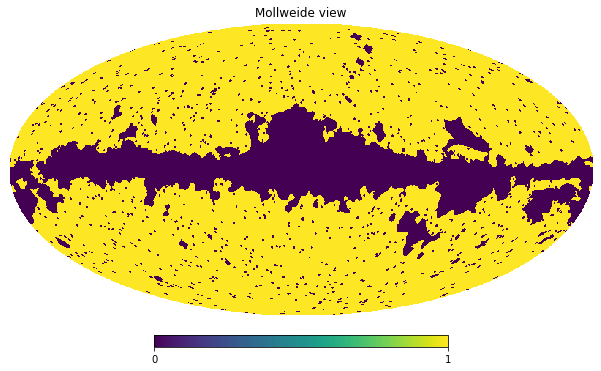

In [6]:
hp.mollview(W)
show()

In [7]:
#bl = np.ones((1,lmax+1)) # beam function
bl = 1./cmb.beam(10.,lmax)
Bl = np.reshape(bl,(1,lmax+1))

In [8]:
# Gaussian alms are generated here
alm, nlm = {}, {}
alm['T'], alm['E'], alm['B'] = cs.utils.gaussTEB(lmax,cl[0,:]*bl**2,cl[1,:]*bl**2,cl[2,:]*bl**2,cl[3,:]*bl**2)
nlm['T'] = cs.utils.gauss1alm(lmax,Nl)
nlm['E'] = cs.utils.gauss1alm(lmax,Nl*2)
nlm['B'] = cs.utils.gauss1alm(lmax,Nl*2)

In [9]:
# fullsky T/Q/U
omap = {}
omap['T'] = cs.utils.hp_alm2map(nside,lmax,lmax,alm['T']+nlm['T'])
omap['Q'], omap['U'] = cs.utils.hp_alm2map_spin(nside,lmax,lmax,2,alm['E']+nlm['E'],alm['B']+nlm['B'])

In [10]:
# alms from masked T/Q/U
olm = {}
olm['T'] = cs.utils.hp_map2alm(nside,lmax,lmax,omap['T']*W)
olm['E'], olm['B'] = cs.utils.hp_map2alm_spin(nside,lmax,lmax,2,omap['Q']*W,omap['U']*W)

In [11]:
# Wiener filtering (test with the trivial case)
# inverse noise covariance
invn = I * (sigma*(np.pi/10800.)/Tcmb)**(-2)
invN = np.reshape(np.array((invn,invn/2.,invn/2.)),(3,1,npix))
# TQU
TQU = np.reshape(np.array((omap['T'],omap['Q'],omap['U'])),(3,1,npix)) # restrict T, Q, U to observed area
# Computing filtered-alms
ilm = {}
ilm['T'], ilm['E'], ilm['B'] = cs.cninv.cnfilter_freq(3,1,nside,lmax,cl[0:3,:],Bl,invN,TQU,chn=1,itns=[1000],eps=[1e-5],filter='W',ro=10,stat='status.txt')

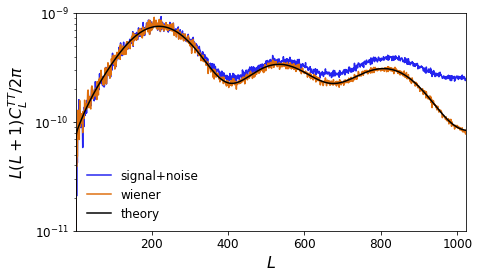

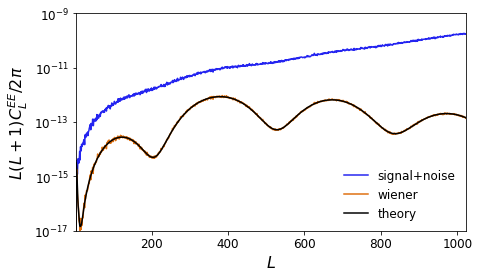

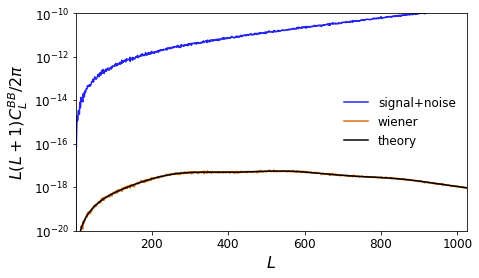

<Figure size 504x288 with 0 Axes>

In [12]:
for i, (m, y0, y1) in enumerate([('T',1e-11,1e-9),('E',1e-17,1e-9),('B',1e-20,1e-10)]):
    pl.plot_1dstyle(fsize=[7,4],xmin=2,xmax=lmax,ymin=y0,ymax=y1,ylog=True,ylab=r'$L(L+1)C_L^{'+m+m+'}/2\pi$')
    cl0 = cs.utils.alm2cl(lmax,olm[m])/w2/bl**2
    cl1 = cs.utils.alm2cl(lmax,ilm[m])
    plot(l,lfac*cl0,label='signal+noise')
    plot(l,lfac*cl1,label='wiener')
    pfac = 1
    if i>=1:  pfac=2
    plot(l,lfac*cl[i,:]**2/(cl[i,:]+Nl*pfac/bl**2),color='k',label='theory')
    legend()
    show()
    clf()

In [13]:
# Wiener filtering (with realistic mask)
# inverse noise covariance
invn = W * (sigma*(np.pi/10800.)/Tcmb)**(-2)
invN = np.reshape(np.array((invn,invn/2.,invn/2.)),(3,1,npix))
# TQU
TQU = np.reshape(np.array((omap['T']*M,omap['Q']*M,omap['U']*M)),(3,1,npix)) # restrict T, Q, U to observed area
# Computing filtered-alms
wlm = {}
wlm['T'], wlm['E'], wlm['B'] = cs.cninv.cnfilter_freq(3,1,nside,lmax,cl[0:3,:],Bl,invN,TQU,chn=1,itns=[1000],eps=[1e-5],filter='W',ro=10,stat='status.txt')

In [14]:
var=!cat 'status.txt'
print(var)

[' precompute diagonal preconditioner', ' |Mb|^2   814.573157781675      |b|^2   1028925.51027320     ', ' initial ratio, |b-Ax|^2/|b|^2  0.330669242228086     ', '          10  9.394600647160774E-004  2.797014824659318E-005', '          20  3.417256243838328E-004  4.274605165601178E-006', '          30  1.388265617244927E-004  1.584053406877609E-006', '          40  4.896681789610400E-005  2.811527288673408E-007', '          50  3.225716954329799E-005  1.757024428677471E-007', '          60  2.683394009651111E-005  1.467228897358385E-007', '          70  2.142101709731886E-005  6.428844633485910E-008', '          80  1.549354776207290E-005  5.659658159883081E-008', '          90  1.488145661619999E-005  4.326083259078199E-008', '          95  9.369340343485853E-006', ' real time:   260.660534000000     ']


/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colorm

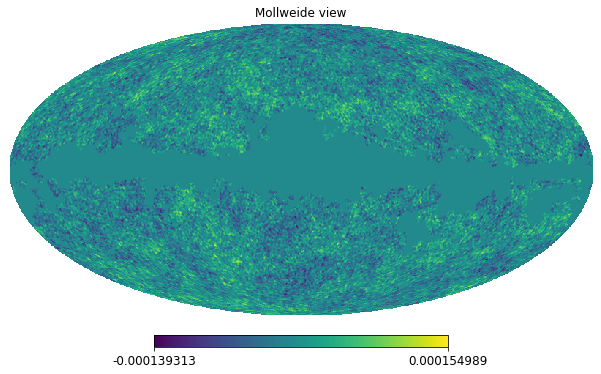

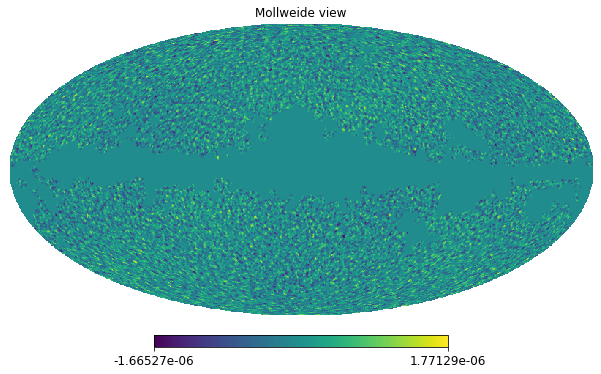

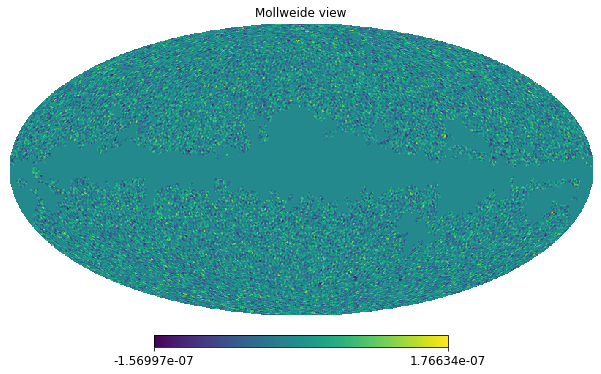

In [15]:
lmax0 = 128*2
nside0 = 128
M0 = hp.ud_grade(M,nside0)
for s in ['T','E','B']:
    Map = M0*cs.utils.hp_alm2map(nside0,lmax0,lmax0,alm[s][:lmax0+1,:lmax0+1])
    hp.mollview(Map)

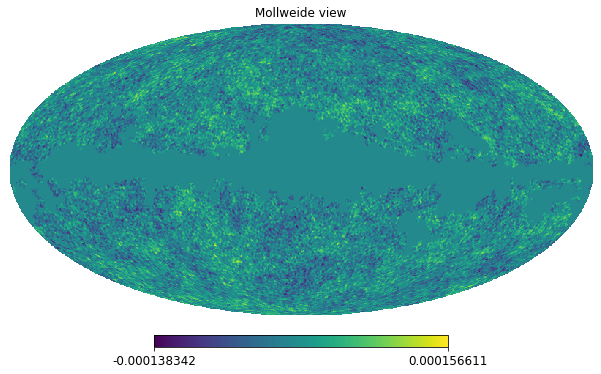

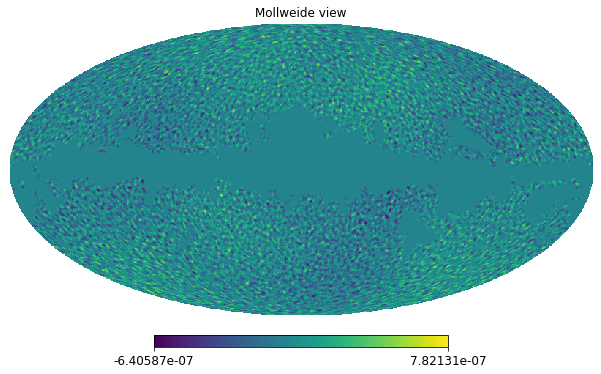

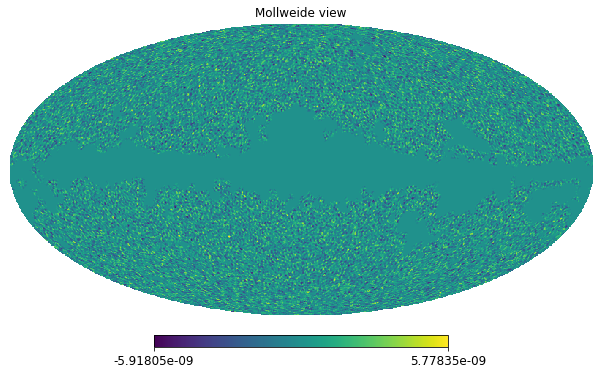

In [16]:
for s in ['T','E','B']:
    wmap = M0*cs.utils.hp_alm2map(nside0,lmax0,lmax0,wlm[s][:lmax0+1,:lmax0+1])
    hp.mollview(wmap)

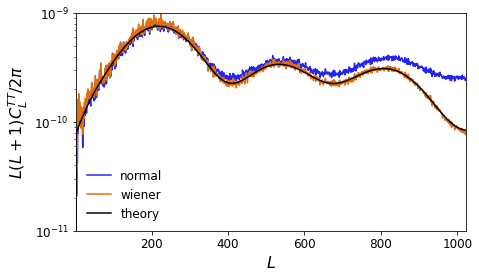

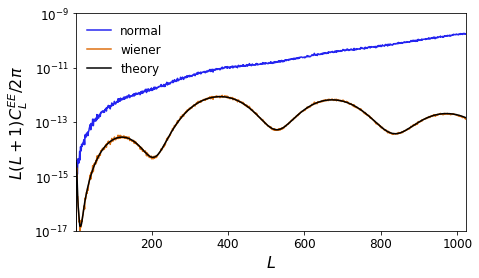

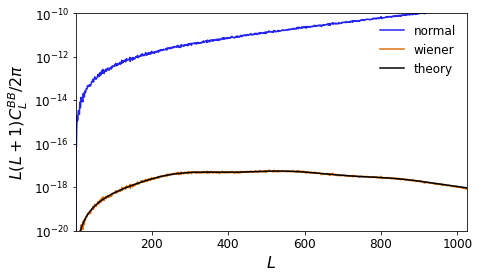

<Figure size 504x288 with 0 Axes>

In [17]:
for i, (m, y0, y1) in enumerate([('T',1e-11,1e-9),('E',1e-17,1e-9),('B',1e-20,1e-10)]):
    pl.plot_1dstyle(fsize=[7,4],xmin=2,xmax=lmax,ymin=y0,ymax=y1,ylog=True,ylab=r'$L(L+1)C_L^{'+m+m+'}/2\pi$')
    cl0 = cs.utils.alm2cl(lmax,olm[m])/w2/bl**2
    cl1 = cs.utils.alm2cl(lmax,wlm[m])/fsky
    plot(l,lfac*cl0,label='normal')
    plot(l,lfac*cl1,label='wiener')
    pfac = 1
    if i>=1:  pfac=2
    plot(l,lfac*cl[i,:]**2/(cl[i,:]+Nl*pfac/bl**2),color='k',label='theory')
    legend()
    show()
    clf()